# Sex Classification Model By Height

Outline: 
1. Load and explore the dataset: shape, datatypes, missing values in data
2. Clean and Proprocess:
   - Label encode sex
3. Visualize data
4. Build classification model to classify sex of person based on height:
   - Scale and normalize mean
   - Fit model
   - Calculate metrics: ROC, Precision, Accuracy, Recall, F1
   - Plot Metric Curves
5. Make predictions with prediction probabilities
6. Plot classification probabilities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load and explore data
def explore_data(df):
    print(f"\nDataset shape: {df.shape}")
    print(f"\nColumn info:")
    print(df.info())
    
    print(f"\nFirst few rows:")
    print(df.head())
    
    print(f"\nBasic statistics:")
    print(df.describe())

    print(f"\nMissing values:")
    print(df.isnull().sum())

    
def load_and_explore_data(file_path):
    """Load and perform initial exploration of the dataset"""
    print("Loading dataset...")
    # import dataset as a pandas DataFrame.
    df = pd.read_csv(file_path)
    explore_data(df)
    
    return df

In [3]:
def clean_and_preprocess_classification_data(df):
    """Clean and preprocess the data for classification of sex based on height"""
    print("\nCleaning and preprocessing data...")
    
    # Create a copy to avoid modifying original
    df_class_clean = df.copy()
    
    # Handle missing values (if any)
    df_class_clean = df_class_clean.dropna()

    # Re-structure data to add fathers and mothers as additional observations
    fathers_df = df_class_clean.groupby('family')['father'].first().rename('height').to_frame()
    fathers_df['sex'] = 'M'
    mothers_df = df_class_clean.groupby('family')['mother'].first().rename('height').to_frame()
    mothers_df['sex'] = 'F'

    df_heights_clean = pd.concat([df_class_clean[['height', 'sex']], fathers_df, mothers_df])
    
    explore_data(df_class_clean)
    explore_data(fathers_df)
    explore_data(mothers_df)
    explore_data(df_heights_clean)

    # Encode sex variable
    le_sex = LabelEncoder()
    df_heights_clean['sex_encoded'] = le_sex.fit_transform(df_heights_clean['sex'])
    
    # Create height percentiles within sex groups
    df_heights_clean['height_percentile'] = df_heights_clean.groupby('sex')['height'].rank(pct=True)
    
    print(f"Cleaned dataset shape: {df_heights_clean.shape}")
    print(f"Sex encoding: {dict(zip(le_sex.classes_, le_sex.transform(le_sex.classes_)))}")

    return df_heights_clean

In [4]:
# 1. Load dataset
# 2. Rearrange and clean data
file_path = 'galton.csv'
df = load_and_explore_data(file_path)
df_heights_clean = clean_and_preprocess_classification_data(df)
male_heights = df_heights_clean[df_heights_clean['sex'] == 'M']
female_heights = df_heights_clean[df_heights_clean['sex'] == 'F']
print("Male heights:")
male_heights.info()
print("Female heights:")
female_heights.info()

Loading dataset...

Dataset shape: (898, 6)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   family  898 non-null    object 
 1   father  898 non-null    float64
 2   mother  898 non-null    float64
 3   sex     898 non-null    object 
 4   height  898 non-null    float64
 5   nkids   898 non-null    int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 42.2+ KB
None

First few rows:
  family  father  mother sex  height  nkids
0      1    78.5    67.0   M    73.2      4
1      1    78.5    67.0   F    69.2      4
2      1    78.5    67.0   F    69.0      4
3      1    78.5    67.0   F    69.0      4
4      2    75.5    66.5   M    73.5      4

Basic statistics:
           father      mother      height       nkids
count  898.000000  898.000000  898.000000  898.000000
mean    69.232851   64.084410   66.760690    6.135857
std      2.4

In [5]:
def create_classification_visualizations(df):
    """Create comprehensive classification visualizations"""
    print("\nCreating visualizations...")
    
    # Set up the plotting area
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Distribution of heights by sex
    plt.subplot(2, 1, 1)
    sns.histplot(data=df, x='height', hue='sex', kde=True, alpha=0.7)
    plt.title('Distribution of Heights by Sex')
    plt.xlabel('Height')
    plt.ylabel('Count')

    # 3. Height percentile by sex
    plt.subplot(2, 1, 2)
    sns.boxplot(data=df, x='sex', y='height_percentile')
    plt.title('Height Percentiles by Sex')
    plt.xlabel('Sex')
    plt.ylabel('Height Percentile')
        
    plt.tight_layout()
    plt.show()


Creating visualizations...


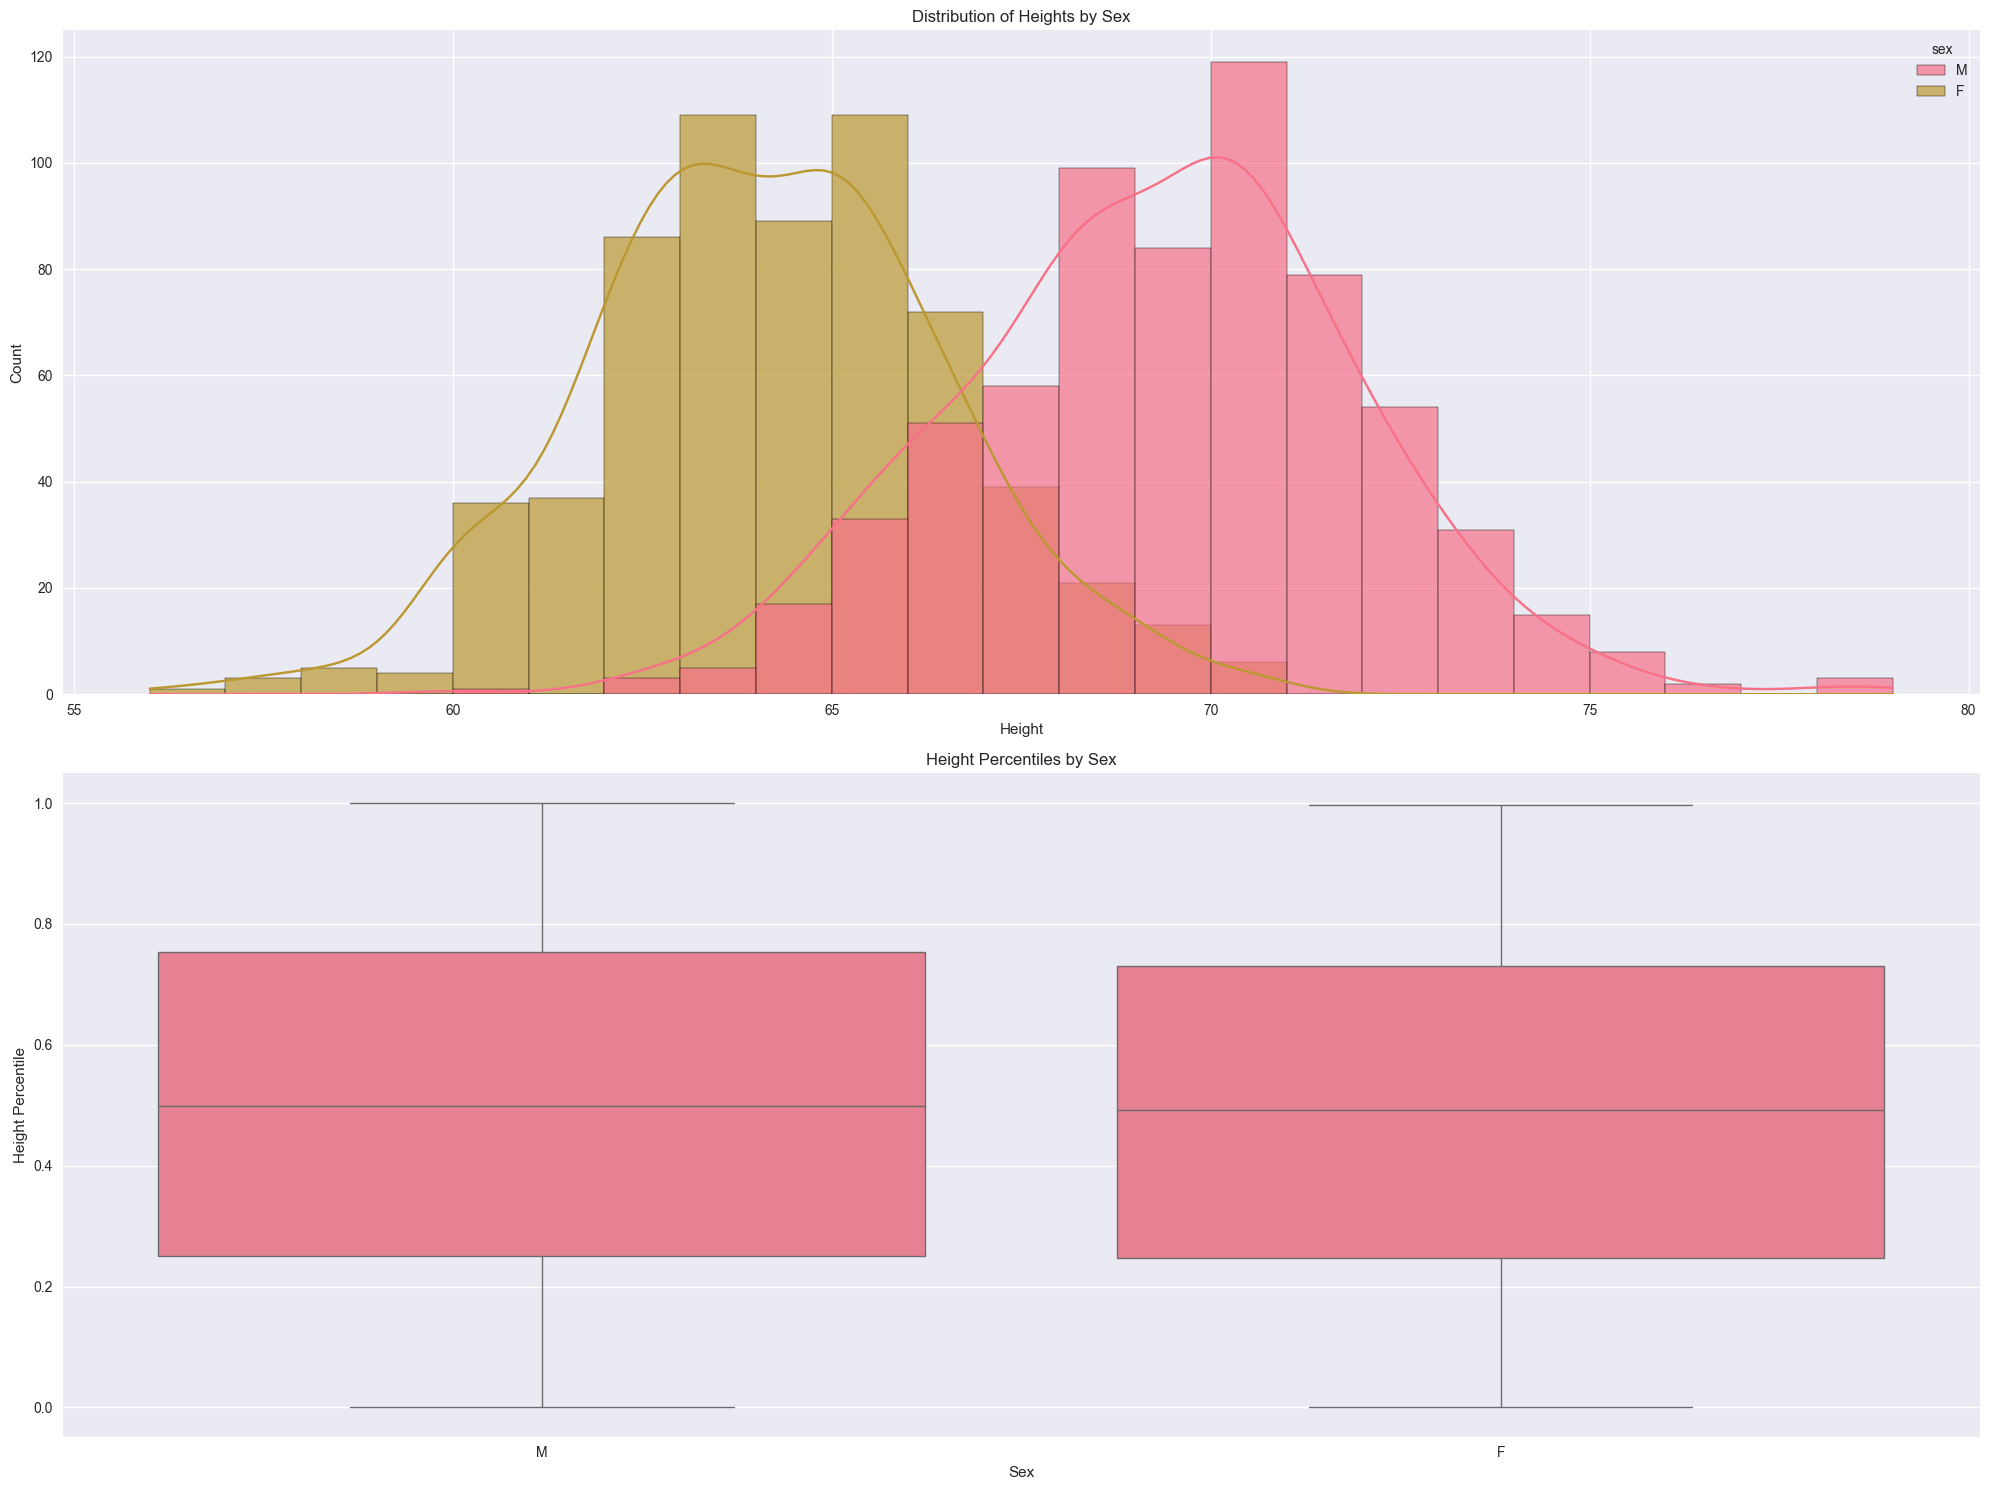

In [6]:
# 3. Create visualizations
create_classification_visualizations(df_heights_clean)

In [7]:
  
def build_sex_classification_model(df):
    """Build classification model"""
    print("\nBuilding logistic regression model...")

    X = df[['height']]
    y = df['sex_encoded']
    # Prepare data        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
    # Create pipeline with scaling and regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LogisticRegression())
    ])
    
    # Fit model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_proba_train = pipeline.predict_proba(X_train)
    y_pred_test = pipeline.predict(X_test)
    y_pred_proba_test = pipeline.predict_proba(X_test)

    print("Test Predictions:", y_pred_test[0:5])
    print("test Prediction Proba:", y_pred_proba_test[0:5])
    
    print("Sex Prediction Model Performance:")
    print(f"Training Score: {pipeline.score(X_train, y_train):.3f}")
    print(f"Test Score: {pipeline.score(X_test, y_test):.3f}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
    print(f"Train AUC-ROC: {roc_auc_score(y_train, y_pred_proba_train[:, 1]):.3f}")
    print(f"Test AUC-ROC: {roc_auc_score(y_test, y_pred_proba_test[:, 1]):.3f}")
    print(f"Train Precision: {precision_score(y_train, y_pred_train):.3f}")
    print(f"Test Precision: {precision_score(y_test, y_pred_test):.3f}")
    print(f"Train Recall: {recall_score(y_train, y_pred_train):.3f}")
    print(f"Test Recall: {recall_score(y_test, y_pred_test):.3f}")
    print(f"Train F1: {f1_score(y_train, y_pred_train):.3f}")
    print(f"Test F1: {f1_score(y_test, y_pred_test):.3f}")

    print("\nTraining Classification Report:")
    print(classification_report(y_train, y_pred_train, target_names=['Female', 'Male']))
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=['Female', 'Male']))

    print("\Confusion Matrix Test:")
    print(confusion_matrix(y_test, y_pred_test))

    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
    from sklearn.calibration import CalibrationDisplay
    from sklearn.inspection import DecisionBoundaryDisplay
    import matplotlib as mpl

    cmap = mpl.cm.viridis
    plt.figure()
    plt.scatter(X_train, y_train, s=20, c=y_pred_train, cmap=cmap, label="Predicted Male")
    scatter = plt.scatter(X_test, y_test, s=20, c=y_pred_test, cmap=cmap, label="Predicted Female")
    plt.yticks([0,1], ['Female', 'Male'])
    
    handles, labels = scatter.legend_elements(prop="colors", num=[0,1]) 
    # Add custom legend
    plt.legend(handles, ['Female', 'Male'], frameon=True, title='Predicted Sex')
    plt.xlabel('Height')
    plt.ylabel('Actual Sex')
    plt.title("Actual vs Predicted Sex By Height")

    rocPlot = RocCurveDisplay.from_predictions(y_test, y_pred_proba_test[:, 1], pos_label=1, name='ROC Curve')
    prPlot = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_test[:, 1], pos_label=1, name='Precision Recall Curve')
    calPlot = CalibrationDisplay.from_predictions(y_test, y_pred_proba_test[:, 1], pos_label=1, name='Calibration Curve')
    plt.show() 

    return pipeline, X_train, X_test, y_train, y_test


Building logistic regression model...
Test Predictions: [0 0 0 0 1]
test Prediction Proba: [[0.97182609 0.02817391]
 [0.92307177 0.07692823]
 [0.94739811 0.05260189]
 [0.98918022 0.01081978]
 [0.01189782 0.98810218]]
Sex Prediction Model Performance:
Training Score: 0.850
Test Score: 0.865
Train Accuracy: 0.850
Test Accuracy: 0.865
Train AUC-ROC: 0.930
Test AUC-ROC: 0.918
Train Precision: 0.866
Test Precision: 0.892
Train Recall: 0.834
Test Recall: 0.847
Train F1: 0.850
Test F1: 0.869

Training Classification Report:
              precision    recall  f1-score   support

      Female       0.83      0.87      0.85       508
        Male       0.87      0.83      0.85       525

    accuracy                           0.85      1033
   macro avg       0.85      0.85      0.85      1033
weighted avg       0.85      0.85      0.85      1033


Test Classification Report:
              precision    recall  f1-score   support

      Female       0.84      0.89      0.86       122
        Mal

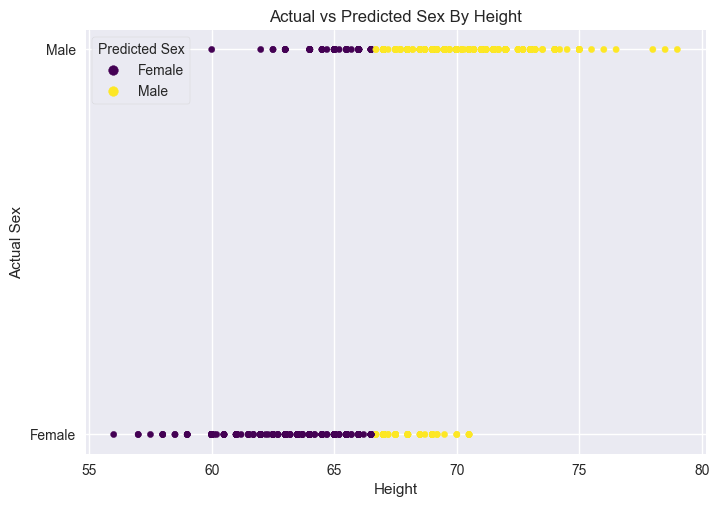

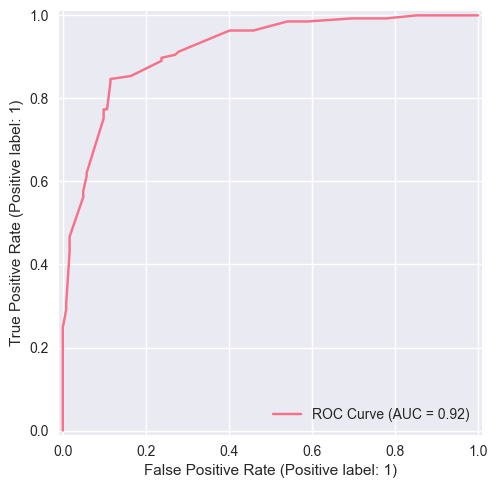

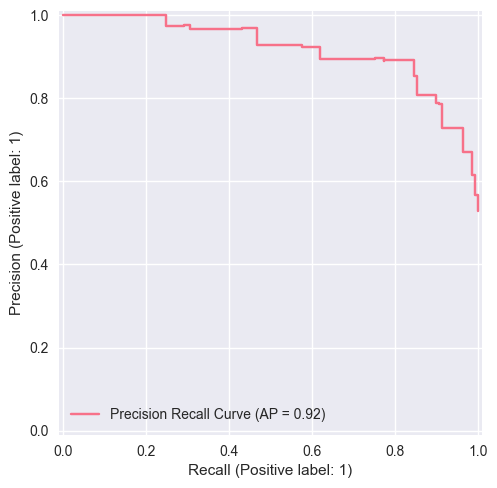

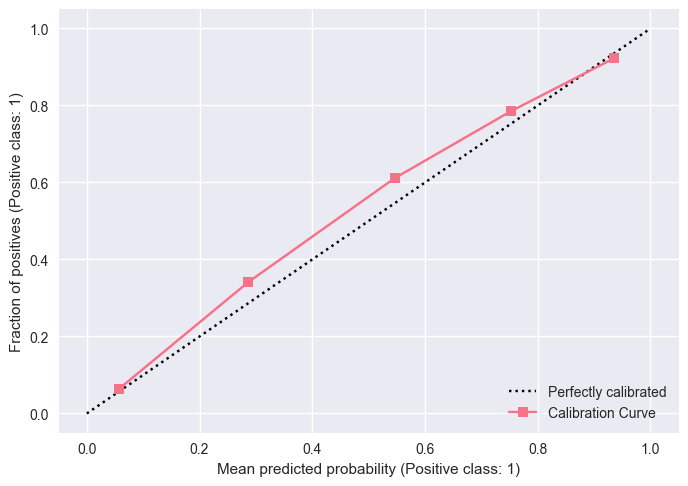

In [8]:
# 4. Build classification model and create metrics
sex_classification_model, X_train, X_test, y_train, y_test = build_sex_classification_model(df_heights_clean)

In [9]:
def calculate_sex_probability(model, height):
    """Calculate P(sex=male | height)"""

    height_array = np.array([[height]])
    probabilities = model.predict_proba(height_array)[0]

    prob_female = probabilities[0] # Probability of class 0 (female)
    prob_male = probabilities[1] # Probability of class 1 (male)
    predicted_sex = 'Male' 
    if prob_male < 0.5: 
        predicted_sex = 'Female'
    confidence = max(prob_male, prob_female)
    
    print(f"Height: {height:.0f}, Predicted Sex: {predicted_sex}, P(sex=male)={prob_male:.4f}, P(sex=female)={prob_female:.4f}, Confidence: {confidence:.4f}")
    return {
        'height': height,
        'prob_male': prob_male,
        'prob_female': prob_female,
        'predicted_sex': predicted_sex,
        'confidence': confidence
    }

In [10]:
#. 5 Make predictions
# Very tall person
print("Very tall person: Expected Male")
calculate_sex_probability(sex_classification_model, 76)
# Expected: P(male) ≈ 0.85, P(female) ≈ 0.15

# Average height
print("Average height: Expected Male")
calculate_sex_probability(sex_classification_model, 67)
# Expected: P(male) ≈ 0.45, P(female) ≈ 0.55

# Very short person  
print("Very short person: Expected Female")
calculate_sex_probability(sex_classification_model, 58)
# Expected: P(male) ≈ 0.05, P(female) ≈ 0.95

# Your specific question
print("Height=70: Expected Male")
calculate_sex_probability(sex_classification_model, 70)
# Expected: P(male) ≈ 0.70, P(female) ≈ 0.30


Very tall person: Expected Male
Height: 76, Predicted Sex: Male, P(sex=male)=0.9995, P(sex=female)=0.0005, Confidence: 0.9995
Average height: Expected Male
Height: 67, Predicted Sex: Male, P(sex=male)=0.5886, P(sex=female)=0.4114, Confidence: 0.5886
Very short person: Expected Female
Height: 58, Predicted Sex: Female, P(sex=male)=0.0010, P(sex=female)=0.9990, Confidence: 0.9990
Height=70: Expected Male
Height: 70, Predicted Sex: Male, P(sex=male)=0.9424, P(sex=female)=0.0576, Confidence: 0.9424


{'height': 70,
 'prob_male': np.float64(0.9423995064226243),
 'prob_female': np.float64(0.05760049357737573),
 'predicted_sex': 'Male',
 'confidence': np.float64(0.9423995064226243)}

In [11]:
def plot_sex_probability_by_height(model, height_range=None):
    """Plot how P(sex=male) changes with height"""
    
    if height_range is None:
        height_range = np.linspace(55, 80, 100)
    
    # Calculate probabilities for each height
    female_probs = []
    for h in height_range:
        prob = model.predict_proba([[h]])[0][0]  # P(female)
        female_probs.append(prob)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Main probability curve
    plt.subplot(2, 1, 1)
    plt.plot(height_range, 1- np.array(female_probs), 'b-', linewidth=2, label='P(Male | Height)')
    plt.plot(height_range, female_probs, 'r-', linewidth=2, label='P(Female | Height)')
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Equal Probability')
    plt.axvline(x=70, color='green', linestyle=':', linewidth=2, label='Height = 70"')
    
    plt.xlabel('Height (inches)')
    plt.ylabel('Probability')
    plt.title('Probability of Sex Given Height')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Highlight specific height
    prob_70 = model.predict_proba([[70]])[0][1]
    plt.plot(70, prob_70, 'go', markersize=10)
    plt.annotate(f'P(Male|70") = {prob_70:.3f}', 
                xy=(70, prob_70), xytext=(72, prob_70 + 0.1),
                arrowprops=dict(arrowstyle='->', color='green'),
                fontsize=12, color='green')
    
    # Distribution of heights by sex (from your data)
    plt.subplot(2, 1, 2)
    # This would use your actual data
    plt.hist(male_heights['height'], alpha=0.5, label='Male Heights', bins=30)
    plt.hist(female_heights['height'], alpha=0.5, label='Female Heights', bins=30)
    plt.axvline(x=70, color='green', linestyle=':', linewidth=2)
    plt.xlabel('Height (inches)')
    plt.ylabel('Count')
    plt.title('Height Distribution by Sex')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

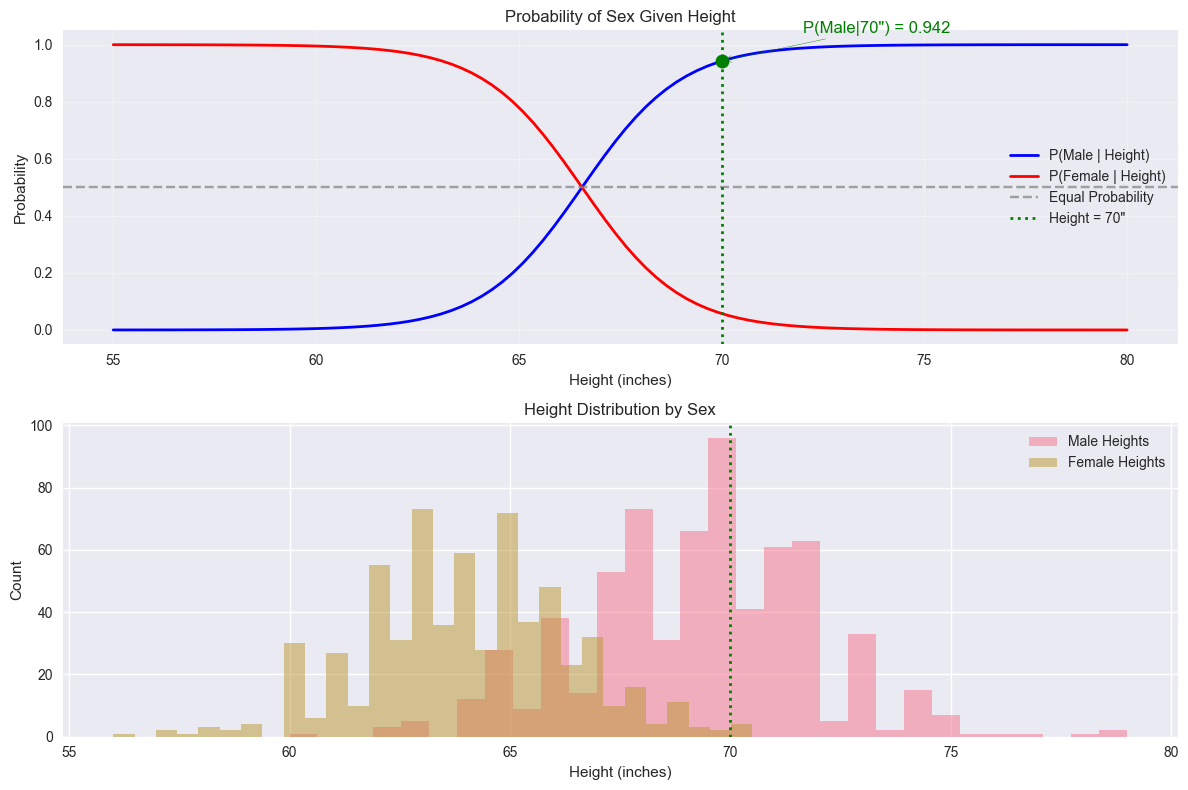

In [12]:
# Plot classification probabilities
plot_sex_probability_by_height(sex_classification_model, height_range=None)